In [20]:
# import the necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random

# Data Visualisations
import matplotlib.pyplot as plt
# Python Image Library
import PIL
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # type: ignore


from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications.resnet50 import ResNet50 # type: ignore
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 # type: ignore
from tensorflow.keras.layers import * # type: ignore
from tensorflow.keras.models import Model, load_model # type: ignore
from tensorflow.keras.initializers import glorot_uniform # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore
from IPython.display import display # type: ignore
from tensorflow.keras import backend as K # type: ignore
from tensorflow.keras.optimizers import SGD, Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler # type: ignore 
from random import sample

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = {}
test = {}

# Path to the dataset
path = "C:\\Users\\njugu\\Documents\\Datasets\\Foods"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "training")
# i - the label for each subdirectory containing images
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "validation")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

In [3]:
# View the number of images in the entire training and testing datasets respectively.
len_train = np.concatenate(list(train.values())).shape[0]
len_test = np.concatenate(list(test.values())).shape[0]

print("Number of images in training data : {}".format(len_train))
print("Number of images in testing data : {}".format(len_test))

Number of images in training data : 9866
Number of images in testing data : 3430


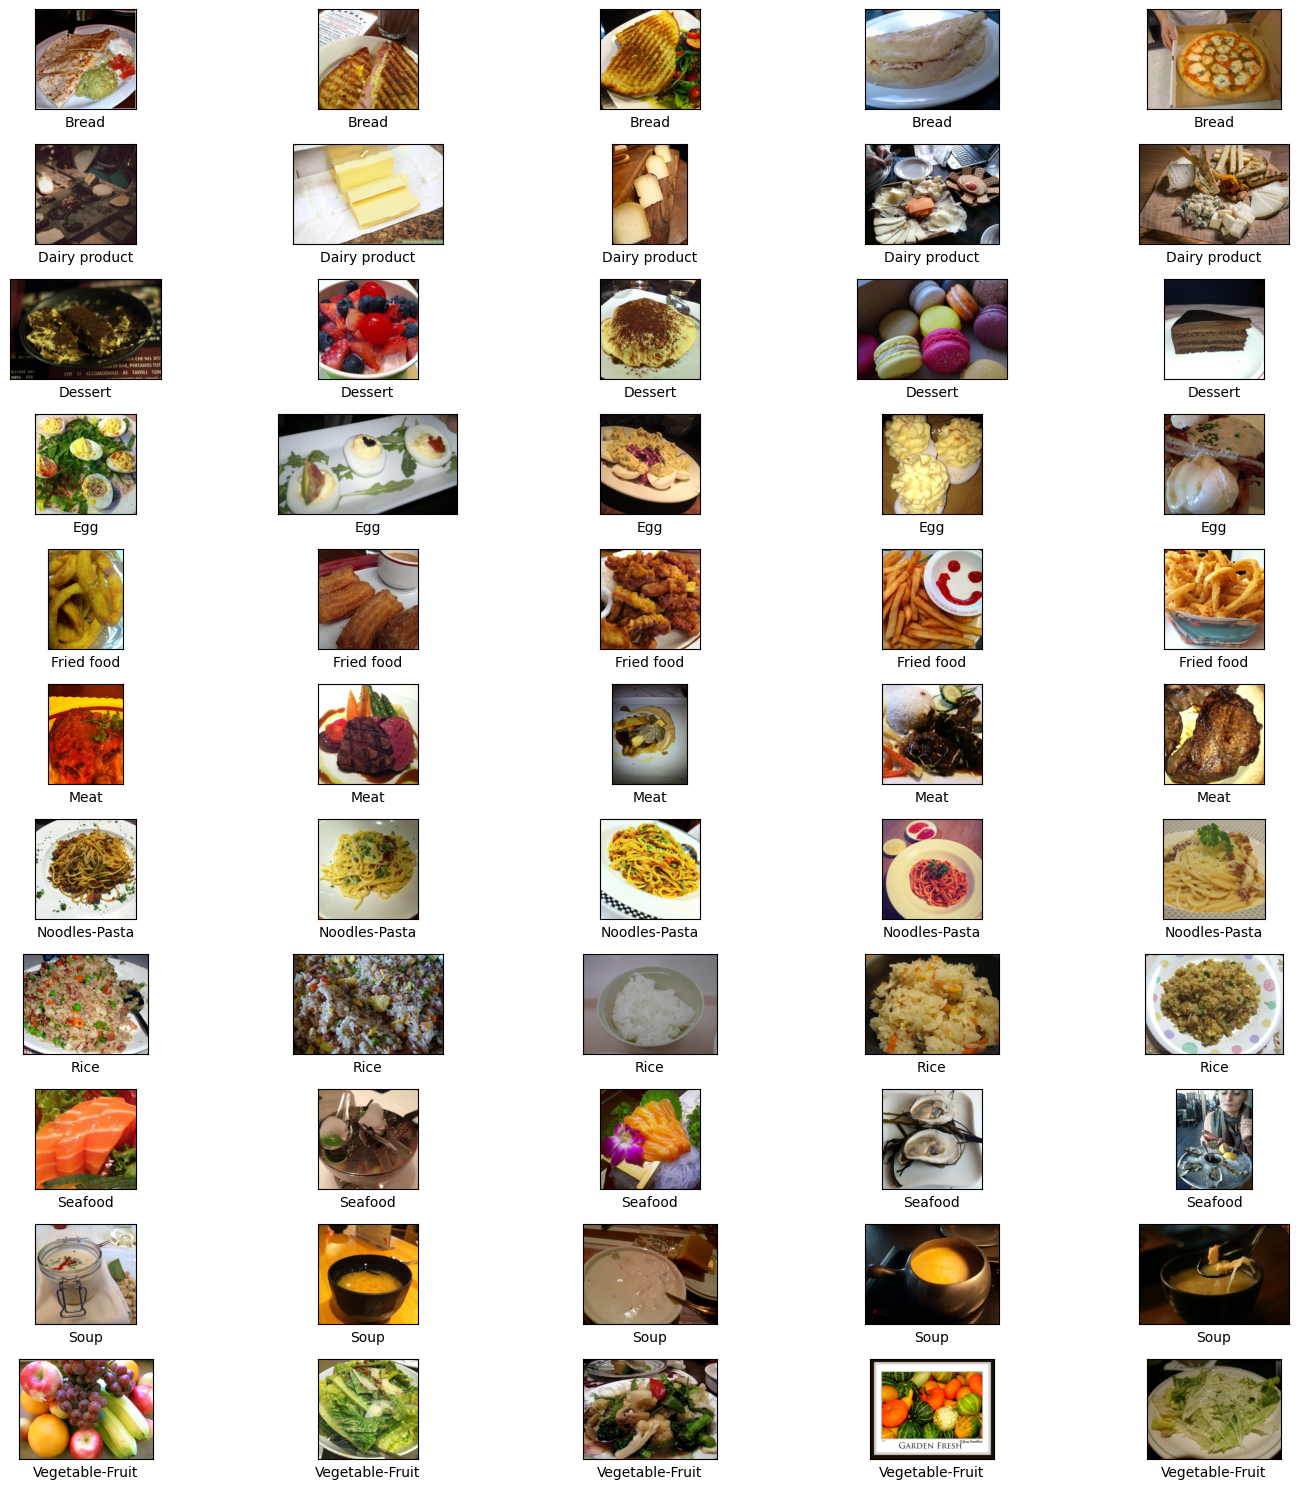

In [4]:
# Randomly display 5 images under each of the 6 categories from the training data.
# You will see different images each time.
fig, axs = plt.subplots(len(train.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)
    
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

In [5]:
# View the number of images in each of the 6 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

Bread 994
Dairy product 429
Dessert 1500
Egg 986
Fried food 848
Meat 1325
Noodles-Pasta 440
Rice 280
Seafood 855
Soup 1500
Vegetable-Fruit 709


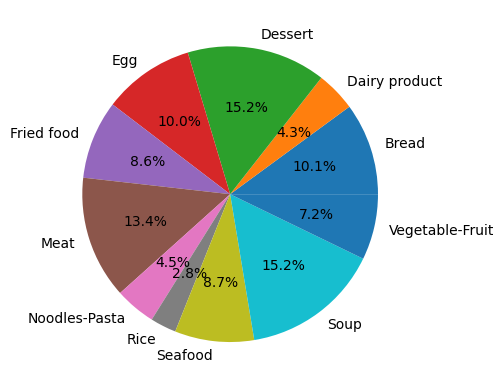

In [6]:
# Make a pie-chart to visualize the percentage contribution of each category.
# This is often useful when you want your dataset to be balanced.
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

In [7]:
# Create an Image Generator and specify the type of data augmentation you want to apply.
# Here we go with zooming, flipping (horizontally and vertically), and rescaling.
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Create a generator for the images. 
# This will make images (including augmented ones) start flowing from the directory to the model.
# Note that augmented images are not stored along with the original images. The process happens in memory.

# Train generator
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [9]:
# Load the inception resnetv2 model
basemodel = InceptionResNetV2(
    weights = "imagenet",
    include_top = False, # Classification layer (output layer- sigmoid activations)
    input_tensor = Input((256, 256, 3))
)

In [10]:
# print the model summary
basemodel.summary()

Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [11]:
# Freeze the basemodel weights, so these weights won't change during training
basemodel.trainable = False

In [12]:
# Add classification head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = "Global_Average_Pool")(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(256, activation = "relu", name = "dense_1")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = "dense_2")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(11, activation = "softmax", name = "output")(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [14]:
# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics = ["accuracy"]
)

In [23]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.keras", 
    verbose = 1, 
    save_best_only = True
)

In [24]:
# Finally, fit the neural network model to the data.
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 1,  
    callbacks = [checkpointer, earlystopping]
)

308/308 ━━━━━━━━━━━━━━━━━━━━ 3723s 12s/step - accuracy: 0.3351 - loss: 2.7023


### Fine tuning

In [25]:
# Unfreeze the weights in the base model, now these weights will be changed during training
basemodel.trainable = True

In [27]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# Save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights_fine.keras", 
    verbose = 1, 
    save_best_only = True
)

In [28]:
# fine tune the model with very low learning rate
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 5, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 3815s 12s/step - accuracy: 0.5279 - loss: 1.4151
Epoch 2/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4062 - loss: 1.5222   
Epoch 3/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 3854s 12s/step - accuracy: 0.5564 - loss: 1.3407
Epoch 4/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5312 - loss: 1.2608  
Epoch 5/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 2998s 10s/step - accuracy: 0.5675 - loss: 1.2872


In [30]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    test_generator, 
    steps = test_generator.n // 32, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

107/107 ━━━━━━━━━━━━━━━━━━━━ 1141s 10s/step - accuracy: 0.7660 - loss: 0.8435
Accuracy Test : 0.7532126307487488


In [31]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

## Model Evaluation

In [ ]:
# Loading images and their predictions 
prediction = []
original = []
image = []
count = 0
path_eval = "C:\\Users\\njugu\\Documents\\Datasets\Foods"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        #code to open the image
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        #resizing the image to (256,256)
        img = img.resize((256,256))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype= np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,256,256,3)
        #making prediction of the model
        predict = model.predict(img)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)

In [ ]:
# Visualizing the results
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
# Check out the Classification Report 
print(classification_report(np.asarray(prediction), np.asarray(original)))

# Based on these values, you can try t improve your model.
# For the sake of simplicity, hyperparameter tuning and model improvement was not done.

In [ ]:
# View the 6x6 confusion matrix
plt.figure(figsize = (7, 5))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cm, 
    annot = True, 
    fmt = "d"
)
plt.show()